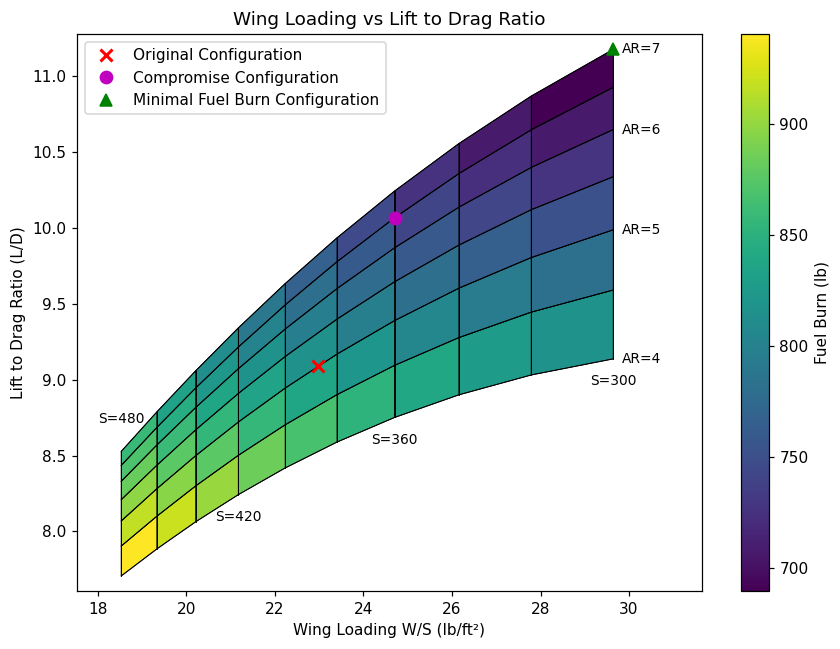

Minimal Fuel Burn Configuration:
  AR = 7.0
  S = 300 ft²
  Fuel Burn = 674.58 lb
  L/D = 11.17
  W/S = 29.64 lb/ft²

Compromise Configuration:
  AR = 6.5
  S = 360 ft²
  Fuel Burn = 745.64 lb
  L/D = 10.06
  W/S = 24.70 lb/ft²


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

W_to_lb = 8893
rho = 2.05e-3 * 515.3788
V = 212 * 0.3048
e, CD0 = 1.10, 0.04048
S0_ft2, AR0 = 387.2, 5.0
W_fuel_actual = 822
W_to_N = W_to_lb * 0.453592 * 9.80665
f_baseline = W_fuel_actual / W_to_lb
S0 = S0_ft2 * 0.092903
CL0 = 2 * W_to_N / (rho * V**2 * S0)
CDi0 = CL0**2 / (np.pi * e * AR0)
LD0 = CL0 / (CD0 + CDi0)
alpha = -LD0 * np.log(1 - f_baseline)

AR_vals = np.arange(4.0, 7.1, 0.5)
S_vals_ft2 = np.arange(300, 481, 20)
WS_vals = W_to_lb / S_vals_ft2
fuel_grid = np.zeros((len(S_vals_ft2), len(AR_vals)))
LD_grid = np.zeros_like(fuel_grid)

for i, S_ft2 in enumerate(S_vals_ft2):
    S_m2 = S_ft2 * 0.092903
    for j, AR in enumerate(AR_vals):
        CL = 2 * W_to_N / (rho * V**2 * S_m2)
        CDi = CL**2 / (np.pi * e * AR)
        LD = CL / (CD0 + CDi)
        LD_grid[i, j] = LD
        fuel_grid[i, j] = (1 - np.exp(-alpha / LD)) * W_to_lb

min_index = np.unravel_index(np.argmin(fuel_grid), fuel_grid.shape)
optimal_S = S_vals_ft2[min_index[0]]
optimal_AR = AR_vals[min_index[1]]
optimal_fuel_burn = fuel_grid[min_index]
optimal_LD = LD_grid[min_index]
optimal_WS = W_to_lb / optimal_S

compromise_fuel_limit = 750
best_S = -np.inf
compromise_result = None

for i, S_ft2 in enumerate(S_vals_ft2):
    for j, AR in enumerate(AR_vals):
        fuel_burn = fuel_grid[i, j]
        if fuel_burn < compromise_fuel_limit and S_ft2 > best_S:
            best_S = S_ft2
            compromise_result = (AR, S_ft2, fuel_burn, LD_grid[i, j], WS_vals[i])

polys, colors = [], []
for i in range(len(S_vals_ft2) - 1):
    for j in range(len(AR_vals) - 1):
        verts = [(WS_vals[i], LD_grid[i, j]),
                 (WS_vals[i], LD_grid[i, j+1]),
                 (WS_vals[i+1], LD_grid[i+1, j+1]),
                 (WS_vals[i+1], LD_grid[i+1, j])]
        polys.append(verts)
        colors.append(fuel_grid[i, j])

fig, ax = plt.subplots(figsize=(8, 6), dpi=110)
pc = PolyCollection(polys, array=np.array(colors), cmap='viridis', edgecolors='k', lw=0.6)
ax.add_collection(pc)
fig.colorbar(pc, ax=ax, label='Fuel Burn (lb)')

for j, AR in enumerate(AR_vals):
    ax.plot(WS_vals, LD_grid[:, j], color='k', lw=0.6)
    if AR in [4.0, 5.0, 6.0, 7.0]:
        i_right = 0
        ax.text(WS_vals[i_right] + 0.2, LD_grid[i_right, j], f"AR={AR:.0f}",
                fontsize=9, ha='left', va='center')

for i, S in enumerate(S_vals_ft2):
    ax.plot(WS_vals[i] * np.ones_like(AR_vals), LD_grid[i, :], color='k', lw=0.6)
    if S in [300, 360, 420]:
        ax.text(WS_vals[i], LD_grid[i, 0] - 0.1, f"S={S}", fontsize=9, ha='center', va='top')
    elif S == 480:
        ax.text(WS_vals[i], LD_grid[i, 0] + 0.99, f"S={S}", fontsize=9, ha='center', va='bottom')

WS_baseline = W_to_lb / S0_ft2
ax.plot(WS_baseline, LD0, 'rx', ms=8, mew=2, label='Original Configuration')

if compromise_result:
    ax.plot(compromise_result[4], compromise_result[3], 'mo', ms=8, label='Compromise Configuration')

ax.plot(optimal_WS, optimal_LD, 'g^', ms=8, label='Minimal Fuel Burn Configuration')

ax.legend(loc='upper left')
ax.set_xlabel('Wing Loading W/S (lb/ft²)')
ax.set_ylabel('Lift to Drag Ratio (L/D)')
ax.set_title('Wing Loading vs Lift to Drag Ratio')
ax.set_xlim(WS_vals[-1] - 1, WS_vals[0] + 2)
ax.set_ylim(LD_grid.min() - 0.1, LD_grid.max() + 0.1)
plt.tight_layout()
plt.show()

print(f"Minimal Fuel Burn Configuration:\n  AR = {optimal_AR}\n  S = {optimal_S} ft²")
print(f"  Fuel Burn = {optimal_fuel_burn:.2f} lb")
print(f"  L/D = {optimal_LD:.2f}")
print(f"  W/S = {optimal_WS:.2f} lb/ft²")

if compromise_result:
    print("\nCompromise Configuration:")
    print(f"  AR = {compromise_result[0]}")
    print(f"  S = {compromise_result[1]} ft²")
    print(f"  Fuel Burn = {compromise_result[2]:.2f} lb")
    print(f"  L/D = {compromise_result[3]:.2f}")
    print(f"  W/S = {compromise_result[4]:.2f} lb/ft²")